In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Matrix multiplication from scratch
In this series, we implement matrix multiplication from scratch. We are only allowed to use:
- python
- python standard library
- matplotlib
- Jupyter notebooks
However, once we have implemented a feature from scratch, we can use its Numpy/PyTorch equivalent.

In [2]:
from pathlib import Path
import pickle, gzip, math, os, time, shutil, matplotlib as mpl, matplotlib.pyplot as plt

## Get data
We use the Fashion-MNIST in this notebook.

In [3]:
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [4]:
X_train, y_train = load_mnist('/content/drive/MyDrive/PDLFC/data/fashion', kind='train')
X_test, y_test = load_mnist('/content/drive/MyDrive/PDLFC/data/fashion', kind='t10k')

In [5]:
type(X_train)

numpy.ndarray

Since we are not allowed to use Numpy (yet), let's typecast the Numpy arrays back to lists.

In [6]:
X_train, y_train = list(X_train), list(y_train)
X_test, y_test = list(X_test), list(y_test)

In [7]:
len(X_train)

60000

In [8]:
len(X_train[0])

784

In [9]:
img = list(X_train[0])
type(img)

list

We have 60k images that are 784 (28*28) pixels each.

## Create iterators to convert 1D list (784) to 2D image (28 by 28)
We shall implement this using 2 methods:
1. `yield`
2. `itertools` `islice`

### `yield`

In [10]:
def chunks(arr, length):
    for i in range(0, len(arr), length):
        yield arr[i: i+length]

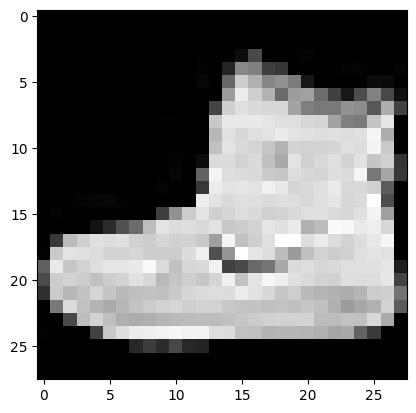

In [11]:
mpl.rcParams['image.cmap'] = 'gray'
plt.imshow(list(chunks(img, 28)))

### `islice`

In [12]:
from itertools import islice

In [13]:
img_iter = iter(img)

In [14]:
list(islice(img_iter, 28))

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [15]:
list(islice(img_iter, 28))

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [16]:
list(islice(img_iter, 28))

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [17]:
list(islice(img_iter, 28))

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 13,
 73,
 0,
 0,
 1,
 4,
 0,
 0,
 0,
 0,
 1,
 1,
 0]

We see that `islice` is working properly.

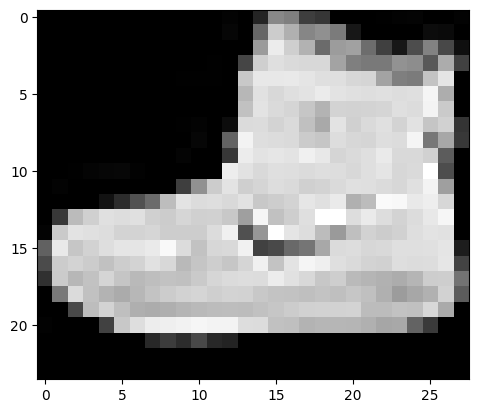

In [18]:
reshaped_img = list(iter(lambda: list(islice(img_iter, 28)), []))
plt.imshow(reshaped_img)

Now that we can reshape our python lists from 1D to 2D, we shall move on to implementing a Matrix class.

## Implementing Matrix class

In [19]:
class Matrix:
    def __init__(self, mat): self.mat = mat
    def __getitem__(self, idx):
        i, j = idx
        return self.mat[i][j]

In [20]:
img_mat = Matrix(reshaped_img)

In [21]:
img_mat[7, 15]

212

We can now use PyTorch's tensor.

In [22]:
from torch import tensor

In [23]:
X_train, y_train, X_test, y_test = map(tensor, (X_train, y_train, X_test, y_test))

<ipython-input-23-4535cbaf2aad>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  X_train, y_train, X_test, y_test = map(tensor, (X_train, y_train, X_test, y_test))


In [24]:
X_train.shape

torch.Size([60000, 784])

In [25]:
X_train = X_train.reshape(-1, 28, 28)

In [26]:
X_train.shape

torch.Size([60000, 28, 28])

## Wichmann Hill random number generator
Wichmann Hill algorithm requires 3 numbers as seed. We shall use the current time to set those seed numbers.

In [27]:
# LCG parameters (adjust as needed)
a = 1664525
c = 1013904223
m = 2**32

global s1, s2, s3
# Initialize a single seed (you can use the seed initialization methods mentioned earlier)
initial_seed = 69

# Function to generate three distinct seeds
def generate_seeds(seed, count):
    seeds = []
    for _ in range(count):
        seed = (a * seed + c) % m
        seeds.append(seed % 30000 + 1)
    return seeds

# Generate three distinct seeds
s1, s2, s3 = generate_seeds(initial_seed, 3)

In [28]:
print(s1, s2, s3)

6449 1632 15443


In [29]:
# Wichmann Hill algorithm
def random_number():
    global s1, s2, s3
    s1 = (171 * s1) % 30269
    s2 = (172 * s2) % 30307
    s3 = (170 * s3) % 30323

    return (s1 / 30269.0 + s2 / 30307.0 + s3 / 30323.0) % 1

In [30]:
random_number()

0.2728144914355908

In [31]:
random_number()

0.3351217283531356

(array([ 983.,  988., 1040., 1024.,  960.,  986., 1049.,  978., 1007.,
         985.]),
 array([1.32909738e-05, 1.00006960e-01, 2.00000629e-01, 2.99994298e-01,
        3.99987967e-01, 4.99981636e-01, 5.99975305e-01, 6.99968974e-01,
        7.99962643e-01, 8.99956312e-01, 9.99949981e-01]),
 <BarContainer object of 10 artists>)

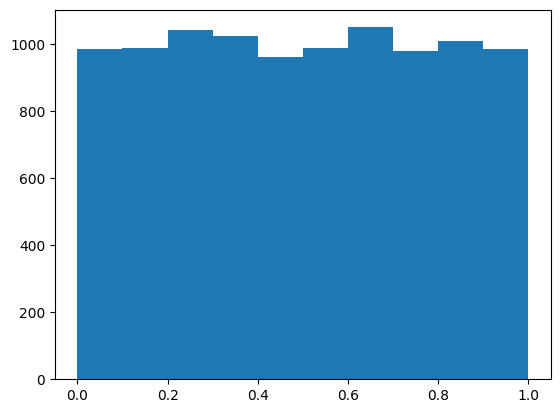

In [32]:
plt.hist([random_number() for _ in range(10000)])

We want to compare the speed difference in our implementation of random number generation and forming a matrix vs PyTorch's.

In [33]:
%timeit -n 10 list(chunks([random_number() for _ in range(7840)], 10))

5.49 ms ± 420 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [34]:
import torch

In [35]:
%timeit -n 10 torch.randn(784,10)

The slowest run took 42.72 times longer than the fastest. This could mean that an intermediate result is being cached.
345 µs ± 715 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


We see that our implementation is approximately 1000 times slower!

## Matrix multiplication
Now that we have figured out how to load our own matrices, it's time to learn how to implement matrix multiplication from scratch.

In [36]:
m1 = X_train[:5]
type(m1)

torch.Tensor

In [37]:
m1.shape

torch.Size([5, 28, 28])

Let's flatten the array for the purpose of this section.

In [38]:
m1 = m1.reshape(m1.shape[0], -1)
m1.shape

torch.Size([5, 784])

In [39]:
# assume there are 10 outcomes
weights = torch.randn((784, 10))
m2 = weights

### Naive matrix multiplication
Let's start with the most naive matrix multiplication, a n^3 iteration.

In [40]:
def naive_mat_mul(m1, m2):
    ar, ac = m1.shape[0], m1.shape[1]
    br, bc = m2.shape[0], m2.shape[1]
    out = torch.zeros((ar, bc))

    for i in range(ar):
        for j in range(ac):
            for k in range(bc):
                out[i, k] += m1[i, j] * m2[j, k]

    return out

In [41]:
out = naive_mat_mul(m1, m2)
out

tensor([[ 2804.3843,  -530.2830, -6412.1870, -4692.4341, -3697.6570, -1736.2729,
          2616.0828,  1487.4958, -3231.0979,   688.2916],
        [ 3275.9614,  3824.2593, -5488.8584, -3258.6362,  3746.9185,   247.3014,
           468.5748,  2131.7478,  3229.5554, -1350.8524],
        [ 1271.9982,  1425.7275, -1110.6102,  -962.6237,  1485.0343,   283.9528,
          1020.5384,  -345.5730,   -61.1591,  -243.6049],
        [ 1762.8263,  2489.5232, -2025.6932, -2162.6101,   387.5354,  -204.5310,
          4592.5469,  1459.4447,  2039.4448, -1672.7025],
        [ 4316.2637,  4227.8608, -2620.1877, -5625.1880,   744.6066,   354.4922,
           992.9981,  1260.8665, -1916.6780, -2057.3921]])

Let's time this naive implementation.

In [42]:
%time _ = naive_mat_mul(m1, m2)

CPU times: user 862 ms, sys: 3.34 ms, total: 865 ms
Wall time: 875 ms


This is slow! It took about half a second.

### Numba
Let's try to use numba for the dot product.

In [43]:
from numba import jit
import numpy as np

In [44]:
@jit(nopython=True)
def dot(a, b):
    total = 0
    for i in range(len(a)):
        total += a[i] * b[i]

    return total

In [45]:
m2[:, 1].shape

torch.Size([784])

In [46]:
def numba_mat_mul(m1, m2):
    ar, ac = m1.shape[0], m1.shape[1]
    br, bc = m2.shape[0], m2.shape[1]
    out = torch.zeros((ar, bc))

    for i in range(ar):
        for k in range(bc):
            out[i, k] = dot(m1[i].numpy(), m2[:, k].numpy())

    return out

In [47]:
out2 = numba_mat_mul(m1, m2)

In [48]:
out2

tensor([[ 2804.3855,  -530.2845, -6412.1875, -4692.4282, -3697.6565, -1736.2734,
          2616.0830,  1487.4956, -3231.0935,   688.2919],
        [ 3275.9622,  3824.2593, -5488.8599, -3258.6362,  3746.9204,   247.3007,
           468.5752,  2131.7473,  3229.5547, -1350.8534],
        [ 1271.9980,  1425.7277, -1110.6097,  -962.6234,  1485.0341,   283.9529,
          1020.5376,  -345.5732,   -61.1589,  -243.6049],
        [ 1762.8262,  2489.5229, -2025.6938, -2162.6106,   387.5369,  -204.5309,
          4592.5464,  1459.4446,  2039.4454, -1672.7015],
        [ 4316.2622,  4227.8613, -2620.1868, -5625.1885,   744.6064,   354.4926,
           992.9982,  1260.8667, -1916.6783, -2057.3918]])

In [49]:
%time _ = numba_mat_mul(m1, m2)

CPU times: user 2.87 ms, sys: 0 ns, total: 2.87 ms
Wall time: 4.75 ms


We see a speed up of close to 200 times!

### Pytorch `sum` and `dot`

In [50]:
(m1[0] * m2[:, 0]).shape

torch.Size([784])

In [51]:
def sum_mat_mul(m1, m2):
    ar, ac = m1.shape[0], m1.shape[1]
    br, bc = m2.shape[0], m2.shape[1]
    out = torch.zeros((ar, bc))

    for i in range(ar):
        for k in range(bc):
            out[i, k] = (m1[i] * m2[:, k]).sum()

    return out

In [52]:
out3 = sum_mat_mul(m1, m2)
out3

tensor([[ 2804.3853,  -530.2844, -6412.1870, -4692.4277, -3697.6558, -1736.2734,
          2616.0833,  1487.4956, -3231.0933,   688.2917],
        [ 3275.9622,  3824.2593, -5488.8594, -3258.6355,  3746.9204,   247.3013,
           468.5754,  2131.7478,  3229.5542, -1350.8534],
        [ 1271.9980,  1425.7278, -1110.6096,  -962.6234,  1485.0341,   283.9530,
          1020.5375,  -345.5732,   -61.1591,  -243.6050],
        [ 1762.8264,  2489.5227, -2025.6940, -2162.6104,   387.5370,  -204.5310,
          4592.5459,  1459.4446,  2039.4452, -1672.7017],
        [ 4316.2627,  4227.8613, -2620.1870, -5625.1885,   744.6068,   354.4927,
           992.9980,  1260.8666, -1916.6787, -2057.3921]])

In [53]:
%time _ = sum_mat_mul(m1, m2)

CPU times: user 2.67 ms, sys: 988 µs, total: 3.66 ms
Wall time: 8 ms


This is faster than our numba implementation, although that may have been slowed down by calling `.numpy()` repeatedly in the inner loop.

In [54]:
def dot_mat_mul(m1, m2):
    ar, ac = m1.shape[0], m1.shape[1]
    br, bc = m2.shape[0], m2.shape[1]
    out = torch.zeros((ar, bc))

    for i in range(ar):
        for k in range(bc):
            out[i, k] = torch.dot(m1[i].float(),  m2[:, k])

    return out

In [55]:
out4 = dot_mat_mul(m1, m2)
out4

tensor([[ 2804.3862,  -530.2843, -6412.1875, -4692.4268, -3697.6562, -1736.2737,
          2616.0818,  1487.4961, -3231.0925,   688.2919],
        [ 3275.9622,  3824.2588, -5488.8594, -3258.6362,  3746.9204,   247.3000,
           468.5771,  2131.7468,  3229.5549, -1350.8529],
        [ 1271.9978,  1425.7273, -1110.6096,  -962.6233,  1485.0338,   283.9527,
          1020.5381,  -345.5734,   -61.1584,  -243.6049],
        [ 1762.8263,  2489.5227, -2025.6932, -2162.6111,   387.5370,  -204.5316,
          4592.5459,  1459.4441,  2039.4458, -1672.7014],
        [ 4316.2607,  4227.8613, -2620.1870, -5625.1885,   744.6062,   354.4926,
           992.9976,  1260.8669, -1916.6780, -2057.3921]])

In [56]:
%time _ = dot_mat_mul(m1, m2)

CPU times: user 1.87 ms, sys: 1 ms, total: 2.87 ms
Wall time: 2.86 ms


### Broadcasting
Now let's try broadcasting where we only have 1 outer loop.

In [57]:
m1[0].shape

torch.Size([784])

In [58]:
m2_transposed = torch.transpose(m2, 1, 0)
m2_transposed.shape

torch.Size([10, 784])

In [59]:
(m1[0] * m2_transposed).shape

torch.Size([10, 784])

In [60]:
(m1[0] * m2_transposed).sum(axis = 1)

tensor([ 2804.3855,  -530.2848, -6412.1875, -4692.4277, -3697.6558, -1736.2734,
         2616.0825,  1487.4954, -3231.0935,   688.2919])

In [61]:
def broadcast_mat_mul(m1, m2):
    ar, ac = m1.shape[0], m1.shape[1]
    br, bc = m2.shape[0], m2.shape[1]
    out = torch.zeros((ar, bc))

    m2_transposed = torch.transpose(m2, 1, 0)
    for i in range(ar):
        out[i] = (m1[i] * m2_transposed).sum(axis=1)

    return out

In [62]:
out5 = broadcast_mat_mul(m1, m2)
out5

tensor([[ 2804.3855,  -530.2848, -6412.1875, -4692.4277, -3697.6558, -1736.2734,
          2616.0825,  1487.4954, -3231.0935,   688.2919],
        [ 3275.9624,  3824.2595, -5488.8599, -3258.6360,  3746.9207,   247.3008,
           468.5747,  2131.7473,  3229.5542, -1350.8530],
        [ 1271.9979,  1425.7275, -1110.6096,  -962.6235,  1485.0342,   283.9528,
          1020.5375,  -345.5731,   -61.1589,  -243.6049],
        [ 1762.8262,  2489.5232, -2025.6938, -2162.6106,   387.5370,  -204.5305,
          4592.5469,  1459.4449,  2039.4453, -1672.7017],
        [ 4316.2622,  4227.8608, -2620.1865, -5625.1885,   744.6064,   354.4923,
           992.9983,  1260.8662, -1916.6780, -2057.3916]])

In [63]:
%time _ = broadcast_mat_mul(m1, m2)

CPU times: user 403 µs, sys: 0 ns, total: 403 µs
Wall time: 411 µs


### Einstein summation

In [64]:
def einsum_mat_mul(a, b):
    return torch.einsum('ij,jk->ik', a, b)

In [65]:
m2.shape

torch.Size([784, 10])

In [66]:
out6 = einsum_mat_mul(m1.float(), m2.float())
out6

tensor([[ 2804.3855,  -530.2849, -6412.1870, -4692.4282, -3697.6572, -1736.2737,
          2616.0820,  1487.4956, -3231.0942,   688.2918],
        [ 3275.9609,  3824.2588, -5488.8584, -3258.6353,  3746.9202,   247.3009,
           468.5741,  2131.7485,  3229.5527, -1350.8534],
        [ 1271.9976,  1425.7273, -1110.6099,  -962.6238,  1485.0344,   283.9529,
          1020.5382,  -345.5734,   -61.1591,  -243.6053],
        [ 1762.8260,  2489.5242, -2025.6936, -2162.6111,   387.5356,  -204.5309,
          4592.5469,  1459.4443,  2039.4456, -1672.7021],
        [ 4316.2627,  4227.8623, -2620.1870, -5625.1890,   744.6056,   354.4920,
           992.9974,  1260.8661, -1916.6771, -2057.3914]])

In [67]:
m1 = m1.float()
m2 = m2.float()

In [68]:
%time _ = einsum_mat_mul(m1, m2)

CPU times: user 134 µs, sys: 9 µs, total: 143 µs
Wall time: 146 µs


Now this is faster than using broadcasting to do our matrix multiplication! We can also use PyTorch's in-built `@` or `torch.matmul`.

In [69]:
%time _ = m1@m2

CPU times: user 185 µs, sys: 13 µs, total: 198 µs
Wall time: 205 µs


In [70]:
%time _ = torch.matmul(m1, m2)

CPU times: user 108 µs, sys: 7 µs, total: 115 µs
Wall time: 130 µs


Surprisingly, `torch.matmul` is the fastest thus far. Now let's try to use CUDA to speed things up via parallelisation.

## CUDA
The fundamental idea behind CUDA/parallelisation is that we can see matrix multiplication of 2 matrices as finding a single element of the output matrix (i, j) at one time. Then, we parallelise finding a single element (i.e. computing each element in parallel).

In [71]:
def cuda_sim_mat_mul(grid, a, b, c):
    i, j = grid # destructuring
    if i < a.shape[0] and j < b.shape[1]:
        tmp = 0.0
        for k in range(a.shape[1]):
            tmp += a[i, k] * b[k, j]

        c[i, j] = tmp

In [72]:
out7 = torch.zeros((m1.shape[0], m2.shape[1]))
cuda_sim_mat_mul((0,0), m1, m2, out7)
out7

tensor([[2804.3843,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
            0.0000,    0.0000,    0.0000,    0.0000],
        [   0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
            0.0000,    0.0000,    0.0000,    0.0000],
        [   0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
            0.0000,    0.0000,    0.0000,    0.0000],
        [   0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
            0.0000,    0.0000,    0.0000,    0.0000],
        [   0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
            0.0000,    0.0000,    0.0000,    0.0000]])

Yep, it is working correctly for our first element. Now we need to do this in parallel. To do so, we need a Nvidia GPU.

In [73]:
from numba import cuda

In [74]:
@cuda.jit
def matmul(a,b,c):
    i, j = cuda.grid(2)
    if i < c.shape[0] and j < c.shape[1]:
        tmp = 0.
        for k in range(a.shape[1]): tmp += a[i, k] * b[k, j]
        c[i,j] = tmp

In [75]:
out8 = torch.zeros((m1.shape[0], m2.shape[1]))
m1c, m2c, out8c = map(cuda.to_device, (m1, m2, out8))

In [76]:
r = m1@m2

In [77]:
# Parameters for CUDA
TPB = 16
rr,rc = r.shape
blockspergrid = (math.ceil(rr / TPB), math.ceil(rc / TPB))
blockspergrid

(1, 1)

In [83]:
%%timeit -n 10
matmul[blockspergrid, (TPB,TPB)](m1c,m2c,out8c)

The slowest run took 12.00 times longer than the fastest. This could mean that an intermediate result is being cached.
382 µs ± 425 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Now let's compare this with our slowest run.

In [82]:
%%timeit -n 10
naive_mat_mul(m1, m2)

822 ms ± 54 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


We see that the naive implementation is over 2000 times slower!